In [7]:
#!pip install biopython transformers datasets huggingface_hub accelerate peft

In [23]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import json
from urllib.request import urlopen
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import AutoModel, AutoTokenizer, DataCollatorWithPadding
from torch.utils.data import DataLoader
import torch


In [28]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(
        examples['sequence'],  # Adjust this key based on your dataset structure
        truncation=True,
        padding=False,
        max_length=512,
    )

In [55]:
def extract_representations(model, dataloader, device='cpu'):
    """
    Extract mean, CLS, and max representations from a model's final hidden layer.

    Args:
        model (torch.nn.Module): The pre-trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for input data.
        device (str): Device to run the model on ('cpu' or 'cuda').

    Returns:
        dict: A dictionary containing mean, CLS, and max representations as Tensors.
    """
    # Move model to device and set to eval mode
    model.to(device)
    model.eval()

    # Initialize lists to store outputs
    mean_outputs = []
    cls_outputs = []
    max_outputs = []

    # Process batches
    with torch.no_grad():
        for batch in dataloader:
            # Move inputs to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Get model outputs
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_state = outputs.last_hidden_state

            # Mask out padding tokens
            expanded_mask = attention_mask.unsqueeze(-1).expand_as(last_hidden_state)
            hidden_state_masked = last_hidden_state * expanded_mask

            # Compute CLS token representation
            cls_token_representation = last_hidden_state[:, 0, :]  # CLS token
            cls_outputs.append(cls_token_representation.cpu())

            # Compute mean pooling (excluding padding tokens)
            sum_hidden_states = hidden_state_masked.sum(dim=1)
            non_padding_tokens = attention_mask.sum(dim=1).unsqueeze(-1)
            mean_representation = sum_hidden_states / non_padding_tokens
            mean_outputs.append(mean_representation.cpu())

            # Compute max pooling
            max_representation, _ = hidden_state_masked.max(dim=1)
            max_outputs.append(max_representation.cpu())

    # Concatenate all outputs
    mean_outputs = torch.cat(mean_outputs, dim=0)
    cls_outputs = torch.cat(cls_outputs, dim=0)
    max_outputs = torch.cat(max_outputs, dim=0)

    print("Processing complete!")
    print(f"Mean outputs shape: {mean_outputs.shape}")
    print(f"CLS outputs shape: {cls_outputs.shape}")
    print(f"Max outputs shape: {max_outputs.shape}")

    return {
        "mean": mean_outputs,
        "cls": cls_outputs,
        "max": max_outputs
    }


In [50]:
def concat_outputs(mean_vec, max_vec, cls_vec, model_type, labels):
    """
    Concatenate outputs of different vector representations with metadata.

    Args:
        mean_vec (torch.Tensor): Mean pooled vectors (NxD).
        max_vec (torch.Tensor): Max pooled vectors (NxD).
        cls_vec (torch.Tensor): CLS token vectors (NxD).
        model_type (str): The name/type of the model used to generate the vectors.
        labels (list or torch.Tensor): Labels corresponding to each input.

    Returns:
        pd.DataFrame: A DataFrame containing concatenated vector representations
                      with added metadata (vector type, model type, and labels).
    """
    # Convert vectors to DataFrames
    df_mean = pd.DataFrame(mean_vec, columns=[f'v_{i}' for i in range(mean_vec.shape[1])])
    df_max = pd.DataFrame(max_vec, columns=[f'v_{i}' for i in range(max_vec.shape[1])])
    df_cls = pd.DataFrame(cls_vec, columns=[f'v_{i}' for i in range(cls_vec.shape[1])])

    # Add metadata to each DataFrame
    df_mean['vec_type'] = "Mean"
    df_max['vec_type'] = "Max"
    df_cls['vec_type'] = "CLS"

    # Add model type and labels
    for df in [df_mean, df_max, df_cls]:
        df['model_type'] = model_type
        df['label'] = labels

    # Concatenate all DataFrames
    concatenated_df = pd.concat([df_mean, df_max, df_cls], axis=0, ignore_index=True)

    return concatenated_df


# Plasmid

In [24]:
model_id = "omicseye/seqsight_4096_512_89M-at-base"

In [25]:
model = AutoModel.from_pretrained(model_id)

In [26]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [19]:
dataset_name = "plasmid_detection"
test_dataset = load_dataset(
    "omicseye/genome_origin_datasets",
    dataset_name,
    split="test",
    streaming=False,
)

/home/ubuntu/anaconda3/envs/torch/lib/python3.9/site-packages/datasets/load.py:1491: FutureWarning: The repository for mahdibaghbanzadeh/genome_origin_datasets contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mahdibaghbanzadeh/genome_origin_datasets
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 95000 examples [00:05, 18348.95 examples/s]
Generating test split: 5000 examples [00:00, 27547.31 examples/s]


In [20]:
test_dataset

Dataset({
    features: ['sequence', 'label'],
    num_rows: 5000
})

In [21]:
test_dataset[0]

{'sequence': 'GCGTGTTTGAATTCGTAAACGGATTTCACGACACGGCAAATGCGGTCGCCACCGTTATCTATACCAGATCGCTTAAACCCCGCACGGCTGTGATCTGGTCGGGGTGCATGAATTTCGTAGGGGTTATCCTGGGCGGGATCAGTGTTGCGTACGGTCTGGTCGAACTGCTGCCCGCCGACGTGCTGTCCCCACCCAACGGCGATCCGGCGGTGCCGATGCTGATATCCCTGTTCGGCACGGCGCTGGCATGGAACCTGTTTACATGGTGGTTCGGGATTCCGAACTCCAGCTCGCATTGCG',
 'label': 1}

In [40]:
plasmid_map = {0:"Chromosome", 1:"Plasmid"}
plasmid_labels = [plasmid_map[label] for label in test_dataset['label']]

In [27]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [31]:
tokenized_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=['sequence'])

Map: 100%|██████████| 5000/5000 [00:00<00:00, 11599.19 examples/s]


In [32]:
tokenized_dataset

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5000
})

In [33]:
# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create DataLoader
batch_size = 64
val_dataloader = DataLoader(
    tokenized_dataset,
    batch_size=batch_size,
    collate_fn=data_collator
)

In [ ]:
# Assuming `model`, `val_dataloader`, and `device` are already defined
representations = extract_representations(model, val_dataloader, device)

mean_outputs = representations["mean"]
cls_outputs = representations["cls"]
max_outputs = representations["max"]

In [51]:
base_model = concat_outputs(mean_vec=mean_outputs,
                           max_vec=max_outputs,
                           cls_vec=cls_outputs,
                           model_type="Base",
                           labels=plasmid_labels)

In [54]:
base_model.to_csv("base_model_plasmid.csv")

In [56]:
model_id = "omicseye/seqsight_4096_512_89M-at-base-finetuned-plasmid"

model = AutoModel.from_pretrained(model_id)

In [58]:
batch_size = 64
val_dataloader = DataLoader(
    tokenized_dataset,
    batch_size=batch_size,
    collate_fn=data_collator
)

In [59]:
# Assuming `model`, `val_dataloader`, and `device` are already defined
representations_fine_tuned = extract_representations(model, val_dataloader, device)

mean_outputs_fine_tuned = representations_fine_tuned["mean"]
cls_outputs_fine_tuned = representations_fine_tuned["cls"]
max_outputs_fine_tuned = representations_fine_tuned["max"]

Processing complete!
Mean outputs shape: torch.Size([5000, 768])
CLS outputs shape: torch.Size([5000, 768])
Max outputs shape: torch.Size([5000, 768])


In [68]:
fine_tuned_model = concat_outputs(mean_vec=mean_outputs_fine_tuned,
                           max_vec=cls_outputs_fine_tuned,
                           cls_vec=max_outputs_fine_tuned,
                           model_type="Fine-tuned",
                           labels=plasmid_labels)
fine_tuned_model.to_csv("fine_tuned_model_plasmid.csv")

# Four kingdoms

In [69]:
model_id = "omicseye/seqsight_4096_512_89M-at-base"

In [70]:
model = AutoModel.from_pretrained(model_id)

In [71]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [72]:
dataset_name = "four_kingdoms"
test_dataset = load_dataset(
    "omicseye/genome_origin_datasets",
    dataset_name,
    split="test",
    streaming=False,
)

/home/ubuntu/anaconda3/envs/torch/lib/python3.9/site-packages/datasets/load.py:1491: FutureWarning: The repository for mahdibaghbanzadeh/genome_origin_datasets contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mahdibaghbanzadeh/genome_origin_datasets
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [73]:
test_dataset

Dataset({
    features: ['sequence', 'label'],
    num_rows: 5000
})

In [74]:
test_dataset[0]

{'sequence': 'AAAATTCCATTGCGATAGTTCACTCATGATGAAAATGCACAATTGATTATTAAAAATGGCACACTGTGTTACTAGATATTACAACTGAAATATATTTTTCGGAAAATTGCCGTTGTTTTTCTAGCCATGTTTTTAAAAAAATATTATAAA',
 'label': 0}

In [75]:
four_kingdoms_map = {0:"Virus", 1:"Bacteria", 2:"Eukaryote", 3:"Archaea"}
four_kingdoms_labels = [four_kingdoms_map[label] for label in test_dataset['label']]

In [76]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [77]:
tokenized_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=['sequence'])

Map: 100%|██████████| 5000/5000 [00:00<00:00, 13638.47 examples/s]


In [78]:
tokenized_dataset

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5000
})

In [79]:
# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create DataLoader
batch_size = 64
val_dataloader = DataLoader(
    tokenized_dataset,
    batch_size=batch_size,
    collate_fn=data_collator
)

In [80]:
# Assuming `model`, `val_dataloader`, and `device` are already defined
representations = extract_representations(model, val_dataloader, device)

mean_outputs = representations["mean"]
cls_outputs = representations["cls"]
max_outputs = representations["max"]

Processing complete!
Mean outputs shape: torch.Size([5000, 768])
CLS outputs shape: torch.Size([5000, 768])
Max outputs shape: torch.Size([5000, 768])


In [81]:
base_model = concat_outputs(mean_vec=mean_outputs,
                           max_vec=max_outputs,
                           cls_vec=cls_outputs,
                           model_type="Base",
                           labels=four_kingdoms_labels)

In [82]:
base_model.to_csv("base_model_four_kingdoms.csv")

In [83]:
model_id = "omicseye/seqsight_4096_512_89M-at-base-finetuned-four_kingdom"

model = AutoModel.from_pretrained(model_id)

In [84]:
batch_size = 64
val_dataloader = DataLoader(
    tokenized_dataset,
    batch_size=batch_size,
    collate_fn=data_collator
)

In [85]:
# Assuming `model`, `val_dataloader`, and `device` are already defined
representations_fine_tuned = extract_representations(model, val_dataloader, device)

mean_outputs_fine_tuned = representations_fine_tuned["mean"]
cls_outputs_fine_tuned = representations_fine_tuned["cls"]
max_outputs_fine_tuned = representations_fine_tuned["max"]

Processing complete!
Mean outputs shape: torch.Size([5000, 768])
CLS outputs shape: torch.Size([5000, 768])
Max outputs shape: torch.Size([5000, 768])


In [86]:
fine_tuned_model = concat_outputs(mean_vec=mean_outputs_fine_tuned,
                           max_vec=cls_outputs_fine_tuned,
                           cls_vec=max_outputs_fine_tuned,
                           model_type="Fine-tuned",
                           labels=four_kingdoms_labels)
fine_tuned_model.to_csv("fine_tuned_model_four_kingdoms.csv")

In [106]:
fine_tuned_model.head()

,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_761,v_762,v_763,v_764,v_765,v_766,v_767,vec_type,model_type,label
0,-0.247654,0.039333,0.100195,0.015271,0.021194,0.416326,0.003399,-0.019746,-0.277146,0.112399,...,0.303932,0.177185,0.121128,-0.262249,-0.049563,-0.020621,0.022412,Mean,Fine-tuned,Virus
1,-0.061669,0.004335,-0.166183,0.465865,-0.307981,-0.111978,-0.231269,0.478159,-0.456773,-0.355878,...,0.175212,-0.057002,-0.105015,0.093398,0.035019,-0.086970,0.176825,Mean,Fine-tuned,Bacteria
2,0.131323,-0.680892,-0.436222,-0.072287,0.457990,-0.058953,-0.111653,0.426696,-0.562376,0.044569,...,0.473868,0.197408,0.158701,0.383869,-0.251097,0.208062,0.041624,Mean,Fine-tuned,Virus
3,-0.094222,0.066685,-0.253934,-0.193876,-0.147078,0.018494,0.109846,0.362336,-0.249855,0.063723,...,0.184187,0.011035,0.062729,-0.149857,0.020274,-0.029722,0.158901,Mean,Fine-tuned,Bacteria
4,-0.372869,0.115260,0.051765,0.293651,-0.420197,-0.229394,-0.091670,0.479758,-0.254335,-0.371521,...,0.110202,-0.145056,0.021674,-0.100445,-0.243684,-0.255952,0.087263,Mean,Fine-tuned,Bacteria


In [26]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap

In [108]:
# Extract features and labels
features = df_vec.filter(regex='^v_').values
labels = df_vec['label'].values

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA with 4 components
pca = PCA(n_components=4)
pca_result = pca.fit_transform(features_scaled)

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each principal component: {explained_variance}")

# Create column names with explained variance
columns_with_variance = [
    f"PC{i+1} ({var:.2%})" for i, var in enumerate(explained_variance)
]

# Create a DataFrame with PCA results and labeled axes
pca_df = pd.DataFrame(data=pca_result, columns=columns_with_variance)
pca_df['Label'] = labels

# Plot pairwise comparison of the first 4 principal components
pairplot = sns.pairplot(pca_df, hue='Label', plot_kws={'alpha': 0.1}, pl)

# Set the title
plt.suptitle('Pairwise Plot of Principal Components with Explained Variance', y=1.02)
plt.show()


SyntaxError: positional argument follows keyword argument (1031571616.py, line 34)

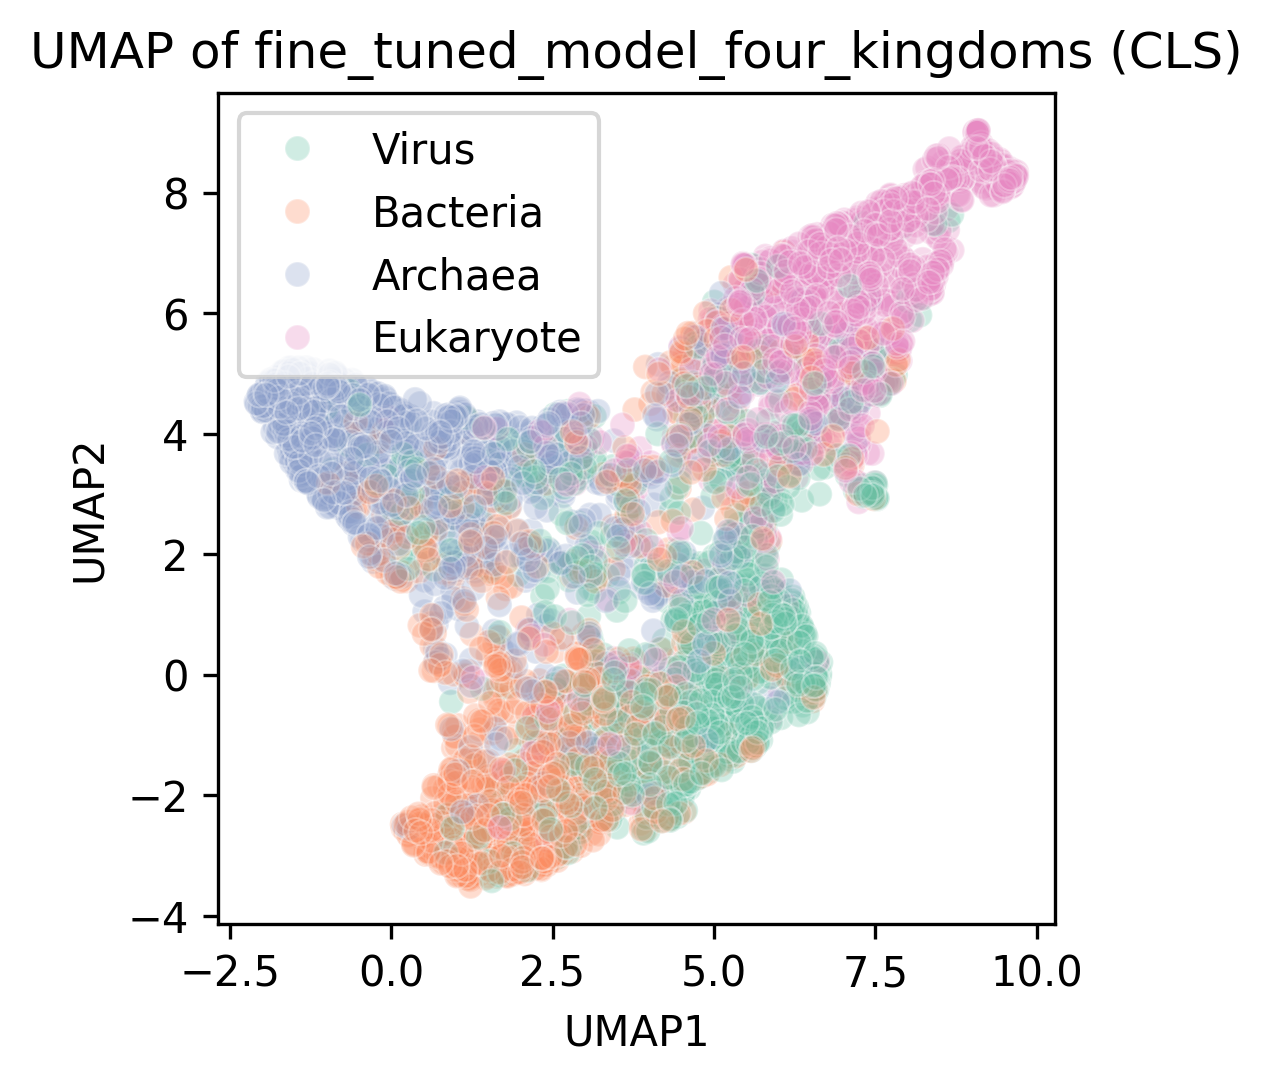

In [21]:
df_files = ['fine_tuned_model_four_kingdoms.csv',
           'base_model_four_kingdoms.csv',
           'fine_tuned_model_plasmid.csv',
           'base_model_plasmid.csv']

for file in df_files:
    file_name = file.split(".")[0]
    # Extract features and labels
    df_vec = pd.read_csv(file,index_col=0)
    vec_types = set(df_vec['vec_type'])
    for vec_type in vec_types:
        tmp = df_vec[df_vec["vec_type"] == vec_type]
        features = tmp.filter(regex='^v_').values
        labels = tmp['label'].values
        break
        # Standardize the features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # Apply PCA with 4 components
        pca = PCA(n_components=4)
        pca_result = pca.fit_transform(features_scaled)

        # Calculate the explained variance
        explained_variance = pca.explained_variance_ratio_
        print(f"Explained variance by each principal component: {explained_variance}")

        # Create column names with explained variance
        columns_with_variance = [
            f"PC{i+1} ({var:.1%})" for i, var in enumerate(explained_variance)
        ]

        # Create a DataFrame with PCA results and labeled axes
        pca_df = pd.DataFrame(data=pca_result, columns=columns_with_variance)
        pca_df['Label'] = labels
        
        # Plot pairwise comparison of the first 4 principal components
        if file_name.endswith("four_kingdoms"):
            pairplot = sns.pairplot(pca_df, hue='Label', 
                                    plot_kws={'alpha': 0.3}, 
                                    palette='Set2',
                                   height=1.8,
                                    aspect=1)
        else:
            pairplot = sns.pairplot(pca_df, hue='Label',
                                    plot_kws={'alpha': 0.3},
                                   height=2.4,
                                    aspect=1)
        
        
        fig_name = f"{file_name}_{vec_type}.pdf"
        print(fig_name)
        plt.show()
        pairplot.savefig(fig_name, bbox_inches='tight')

In [24]:
"four" in "base_model_plasmid.csv"

False

In [27]:
df_files = [
    'fine_tuned_model_four_kingdoms.csv',
    'base_model_four_kingdoms.csv',
    'fine_tuned_model_plasmid.csv',
    'base_model_plasmid.csv'
]

plasmid = pd.DataFrame()
four_kingdoms = pd.DataFrame()

for file in df_files:
    file_name = file.split(".")[0]
    # Extract features and labels
    df_vec = pd.read_csv(file, index_col=0)
    vec_types = df_vec['vec_type'].unique()  # Efficient way to get unique values
    
    for vec_type in vec_types:
        tmp = df_vec[df_vec["vec_type"] == vec_type]
        features = tmp.filter(regex='^v_').values
        labels = tmp['label'].values
        
        # Standardize the features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        # UMAP Reduction
        reducer = umap.UMAP(random_state=42)
        embedding = reducer.fit_transform(features_scaled)
        
        # Create UMAP DataFrame
        umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
        umap_df['Label'] = labels
        umap_df['vec_type'] = vec_type
        umap_df['fine_tuned'] = "Yes" if "fine" in file else "No"
        
        # Append to the respective DataFrame
        if "plasmid" in file:
            plasmid = pd.concat([plasmid, umap_df], ignore_index=True)
        else:
            four_kingdoms = pd.concat([four_kingdoms, umap_df], ignore_index=True)

# Check the resulting DataFrames
print(f"Plasmid DataFrame Shape: {plasmid.shape}")
print(f"Four Kingdoms DataFrame Shape: {four_kingdoms.shape}")


/home/ubuntu/anaconda3/envs/torch/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ubuntu/anaconda3/envs/torch/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ubuntu/anaconda3/envs/torch/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ubuntu/anaconda3/envs/torch/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ubuntu/anaconda3/envs/torch/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ubuntu/anaconda3/envs/torch/lib/python3.9/site-package

Plasmid DataFrame Shape: (30000, 5)
Four Kingdoms DataFrame Shape: (30000, 5)


In [28]:
plasmid.head()

,UMAP1,UMAP2,Label,vec_type,fine_tuned
0,6.221761,9.237298,Plasmid,Mean,Yes
1,12.383291,9.463043,Plasmid,Mean,Yes
2,6.156451,11.003869,Plasmid,Mean,Yes
3,11.221390,9.909326,Plasmid,Mean,Yes
4,12.138625,9.366051,Plasmid,Mean,Yes


In [29]:
plasmid.to_csv("plasmid_umap.csv", index=False)
four_kingdoms.to_csv("four_kingdoms_umap.csv", index=False)

In [ ]:

plt.figure(figsize=(3.6, 3.6), dpi=300)  # Adjust figure size as needed

if file_name.endswith("four_kingdoms"):
    # Plot UMAP
    scatter_plot = sns.scatterplot(data=umap_df,
                                  x="UMAP1", y="UMAP2", 
                                  hue="Label",
                                  alpha=0.3,
                                  palette='Set2')
else:
    scatter_plot = sns.scatterplot(data=umap_df,
                                  x="UMAP1", y="UMAP2", 
                                  hue="Label",
                                  alpha=0.3,
                                  )


fig_name = f"{file_name}_{vec_type}_umap.pdf"
# Add title and labels for better clarity
scatter_plot.set_title(f"UMAP of {file_name} ({vec_type})")
scatter_plot.set_xlabel("UMAP1")
scatter_plot.set_ylabel("UMAP2")
scatter_plot.legend(title=None)

# Save the plot
fig_name = f"{file_name}_{vec_type}_umap.pdf"
plt.savefig(fig_name, bbox_inches="tight")
plt.show()


In [ ]:
# Assuming `features_scaled` is the standardized feature matrix and `labels` are the labels for coloring.
def plot_umap(features_scaled, labels, n_neighbors=15, min_dist=0.1, metric='euclidean', figsize=(8, 6), title="UMAP Projection"):
    # Apply UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=42)
    embedding = reducer.fit_transform(features_scaled)

    # Create a DataFrame for easier plotting
    umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
    umap_df['Label'] = labels

    # Plot UMAP
    plt.figure(figsize=figsize, dpi=300)
    scatter = plt.scatter(umap_df["UMAP1"], umap_df["UMAP2"], c=umap_df["Label"].astype('category').cat.codes, alpha=0.6, cmap='viridis')
    plt.colorbar(scatter, label="Labels")
    plt.title(title)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

In [6]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(features)

/home/ubuntu/anaconda3/envs/torch/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

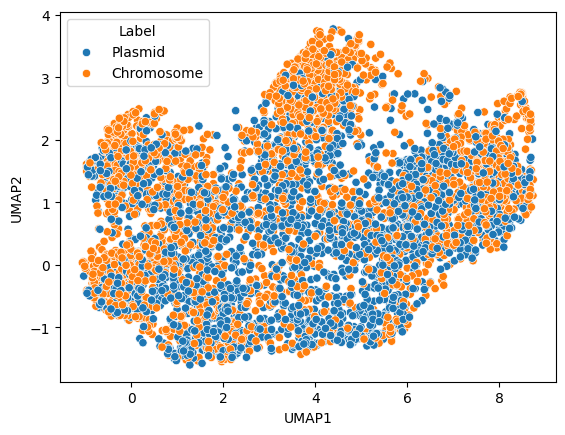

In [12]:
# Create a DataFrame for easier plotting
umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
umap_df['Label'] = labels

# Plot UMAP
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Label")
# plt.show()